In [1]:
!pip install squarify
!pip install plotly-express

In [4]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

#Tensorflow for Multipplex Layer

import tensorflow
from keras.models import Sequential
from keras.layers import Dense

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

age_details = pd.read_csv('data/AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('data/covid_19_india.csv')
hospital_beds = pd.read_csv('data/HospitalBedsIndia.csv')
individual_details = pd.read_csv('data/IndividualDetails.csv')
ICMR_details = pd.read_csv('data/ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv('data/ICMRTestingLabs.csv')
state_testing = pd.read_csv('data/StatewiseTestingDetails.csv')
population = pd.read_csv('data/population_india_census2011.csv')

world_population = pd.read_csv('data/population_by_country_2020.csv')
confirmed_df = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('data/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('data/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])
ICMR_details['DateTime'] = pd.to_datetime(ICMR_details['DateTime'],dayfirst = True)
ICMR_details = ICMR_details.dropna(subset=['TotalSamplesTested', 'TotalPositiveCases'])

In [8]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,8586,8682,8818,8868,8946,9038,9083,9083,9194,9308
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,18254,18343,18425,18613,18679,18765,18875,18926,19011,19093


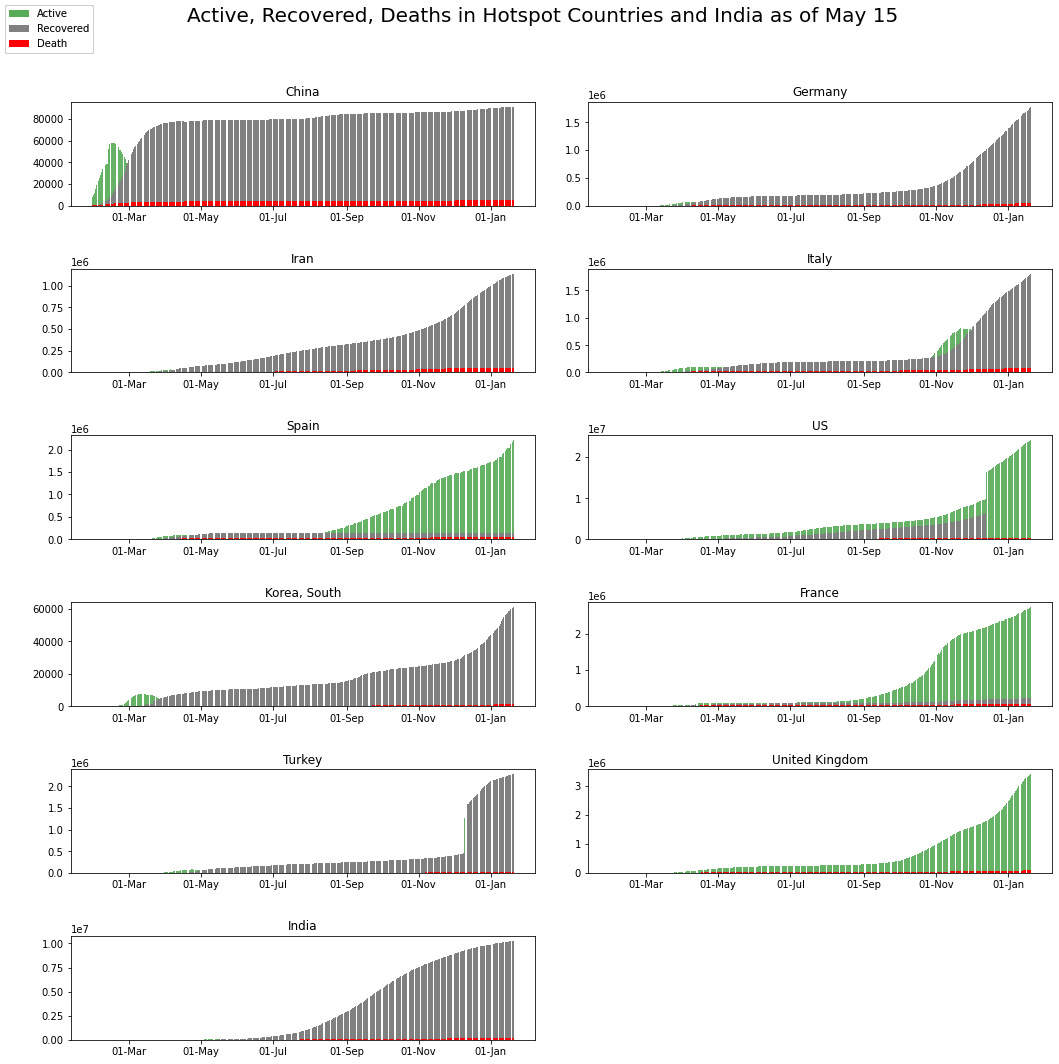

In [6]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of May 15',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)


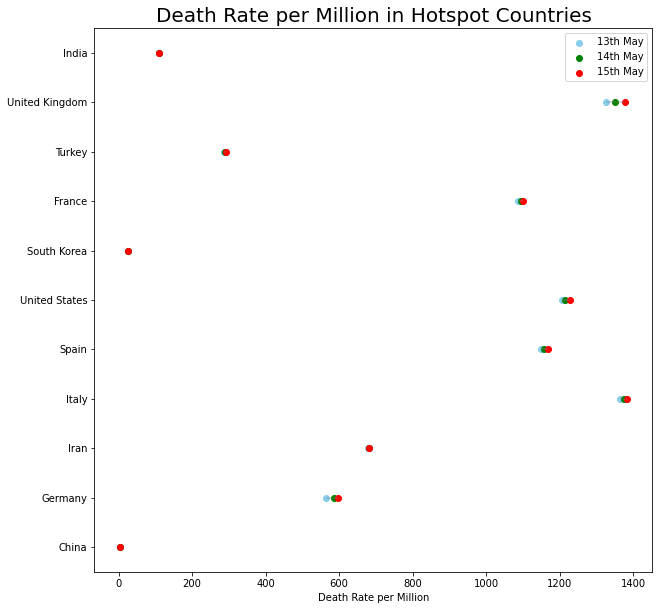

In [10]:
hotspots = ['China','Germany','Iran','Italy','Spain','United States','South Korea','France','Turkey','United Kingdom','India']
country_death_rate = pd.DataFrame(columns = ['country','day1','day2','day3'])
world_population['Population (2020)'] = world_population['Population (2020)']/1000000

d1=[]
d2 =[]
d3 = []
for country in hotspots:
    p = float(world_population[world_population['Country (or dependency)'] == country ]['Population (2020)'])
    if country == 'United States':
        k = global_deaths['US'][-3:]
    elif country == 'South Korea':
        k = global_deaths['Korea, South'][-3:]
    else:
        k = global_deaths[country][-3:]
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))

country_death_rate['country'] = hotspots
country_death_rate['day1'] = d1
country_death_rate['day2'] = d2
country_death_rate['day3'] = d3    

plt.figure(figsize= (10,10))
plt.hlines(y=country_death_rate['country'], xmin=country_death_rate['day1'], xmax=country_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(country_death_rate['day1'], country_death_rate['country'], color='skyblue', label='13th May');
plt.scatter(country_death_rate['day2'], country_death_rate['country'], color='green', label='14th May');
plt.scatter(country_death_rate['day3'], country_death_rate['country'], color='red', label='15th May');
plt.legend();
plt.title("Death Rate per Million in Hotspot Countries",fontsize=20);
plt.xlabel('Death Rate per Million');

India Updates

Age Group Analysis

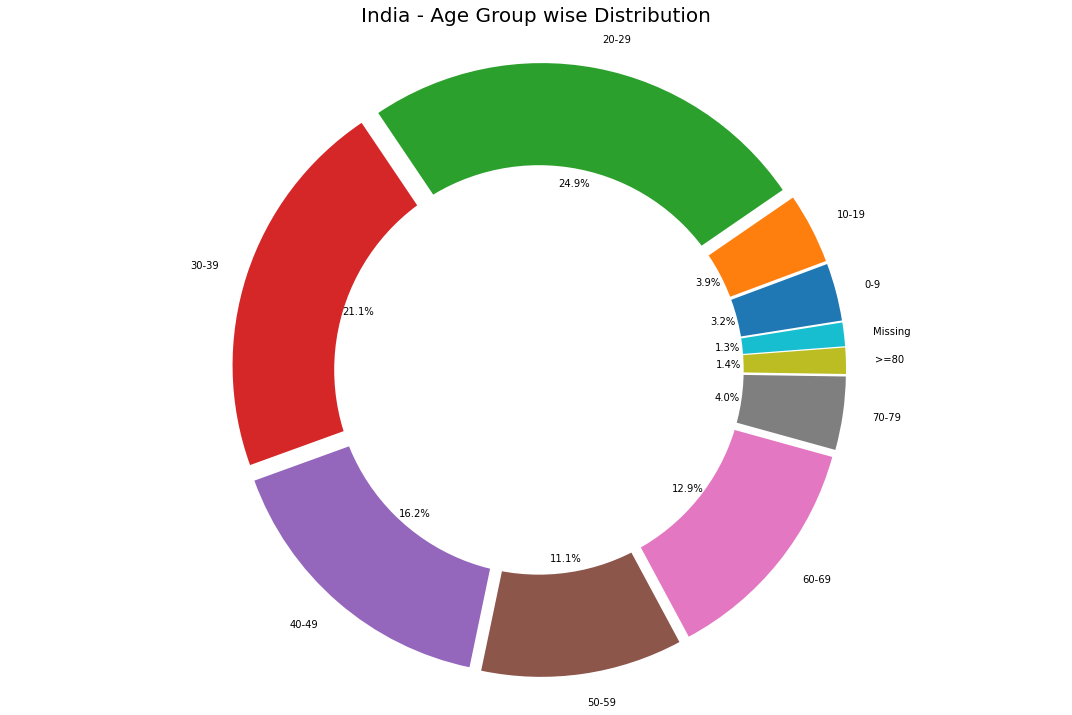

In [11]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

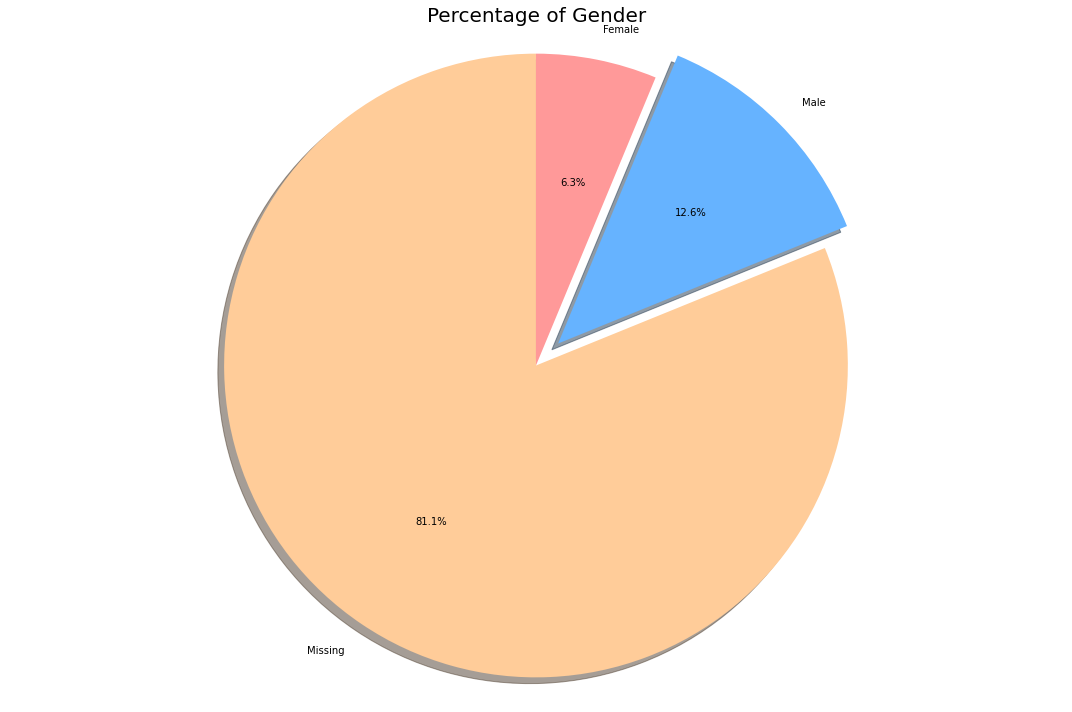

In [12]:
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

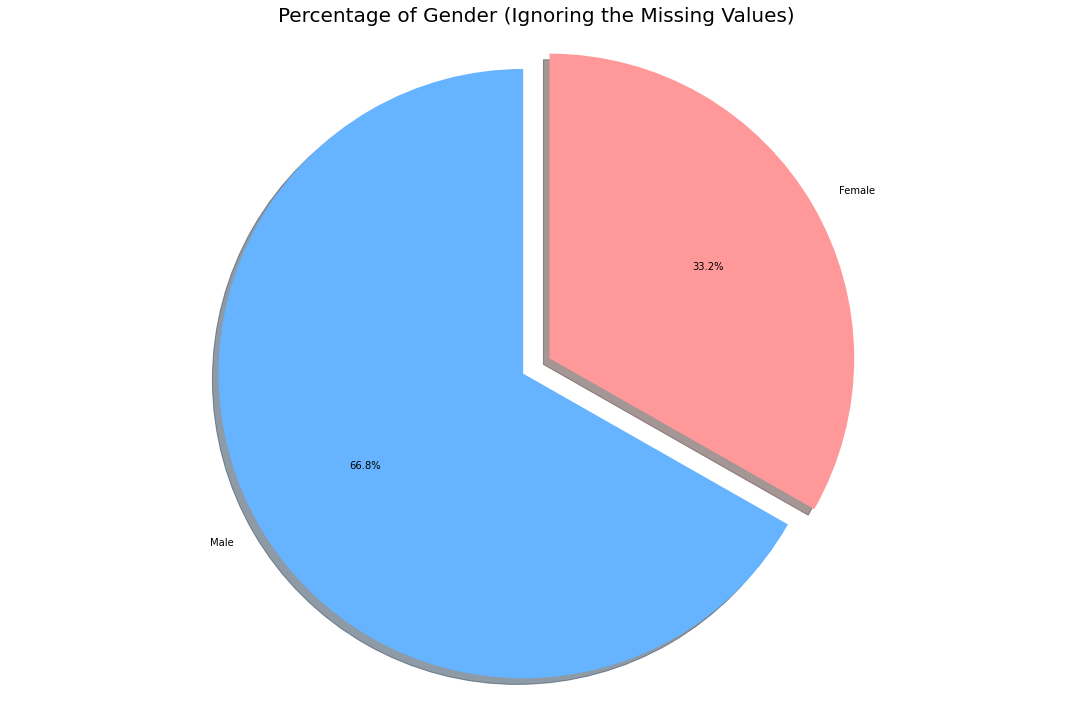

In [13]:
labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 20)
plt.axis('equal')
plt.tight_layout()

In [14]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

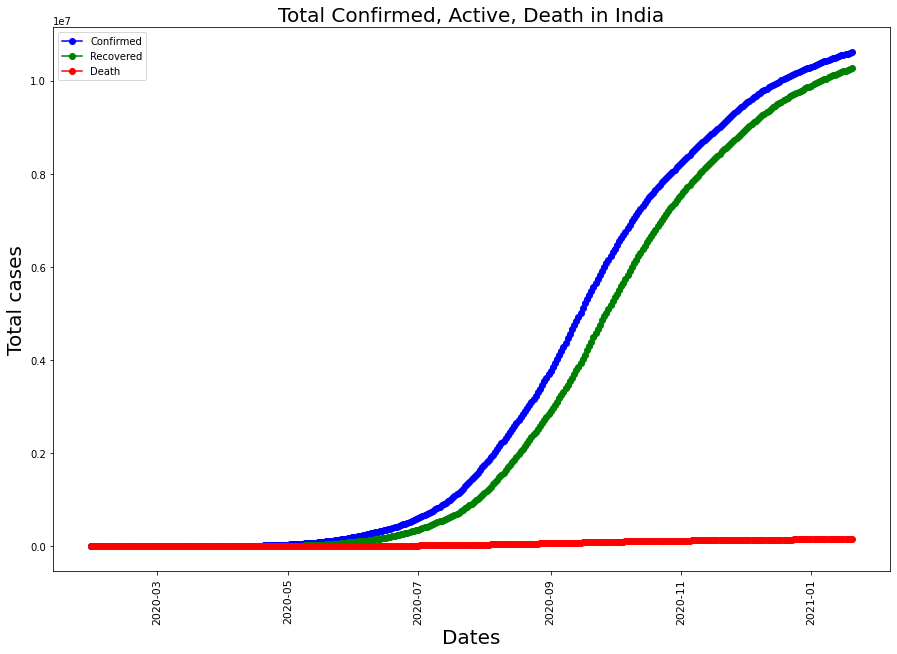

In [15]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

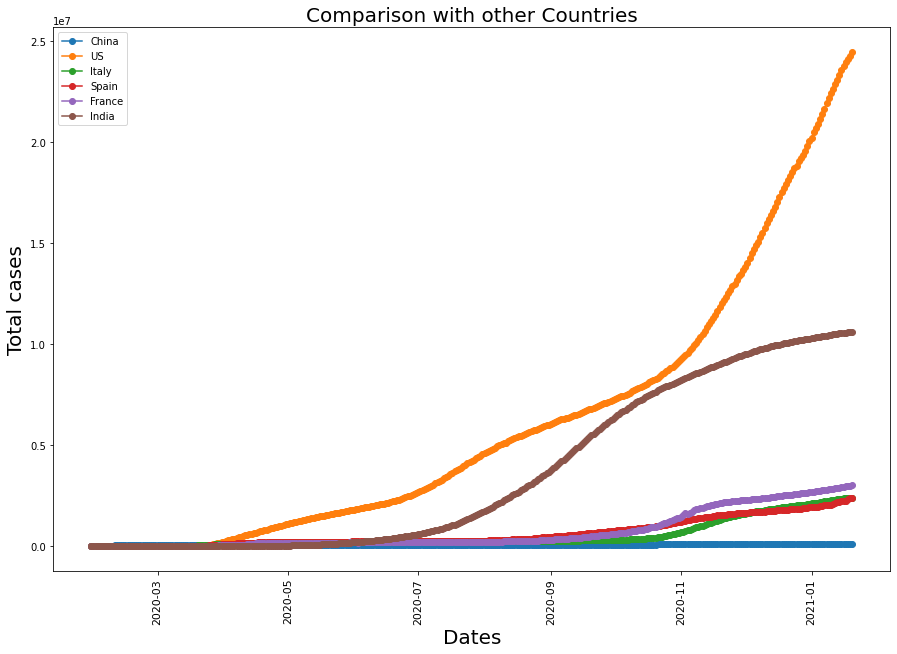

In [16]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

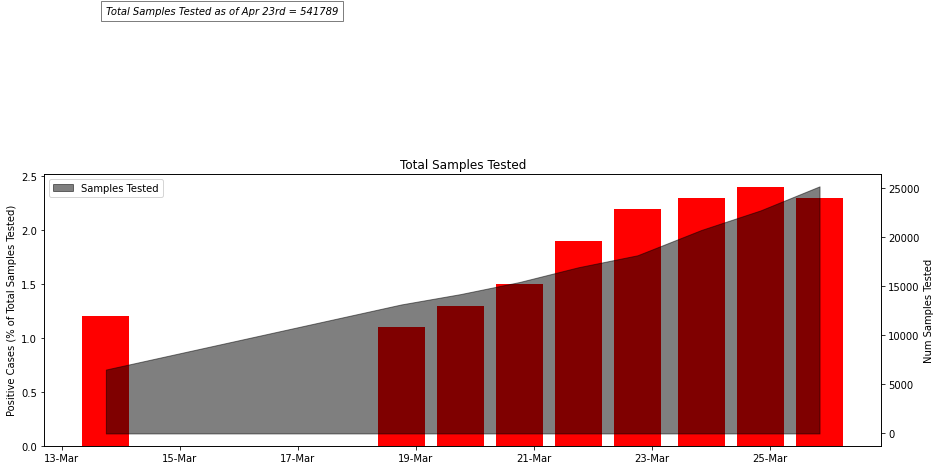

In [17]:
ICMR_details['Percent_positive'] = round((ICMR_details['TotalPositiveCases']/ICMR_details['TotalSamplesTested'])*100,1)

fig, ax1 = plt.subplots(figsize= (15,5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax1.set_ylabel('Positive Cases (% of Total Samples Tested)')
ax1.bar(ICMR_details['DateTime'] , ICMR_details['Percent_positive'], color="red",label = 'Percentage of Positive Cases')
ax1.text(ICMR_details['DateTime'][0],4, 'Total Samples Tested as of Apr 23rd = 541789', style='italic',fontsize= 10,
        bbox={'facecolor': 'white' ,'alpha': 0.5, 'pad': 5})

ax2 = ax1.twinx()  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.set_ylabel('Num Samples Tested')
ax2.fill_between(ICMR_details['DateTime'],ICMR_details['TotalSamplesTested'],color = 'black',alpha = 0.5,label = 'Samples Tested');

plt.legend(loc="upper left")
plt.title('Total Samples Tested')
plt.show()

Statewise Insights 

In [18]:
state_cases = india_covid_19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()

#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
22,Maharashtra,400651,14463,239755,146433,3.61,59.84
32,Tamil Nadu,234114,3741,172883,57490,1.6,73.85
11,Delhi,133310,3907,118633,10770,2.93,88.99
1,Andhra Pradesh,120390,1213,55406,63771,1.01,46.02
18,Karnataka,112504,2147,42901,67456,1.91,38.13
39,Uttar Pradesh,77334,1530,45807,29997,1.98,59.23
41,West Bengal,65258,1490,44116,19652,2.28,67.6
13,Gujarat,59126,2396,43195,13535,4.05,73.06
35,Telengana,58906,492,43751,14663,0.84,74.27
36,Telengana***,57142,480,42909,13753,0.84,75.09


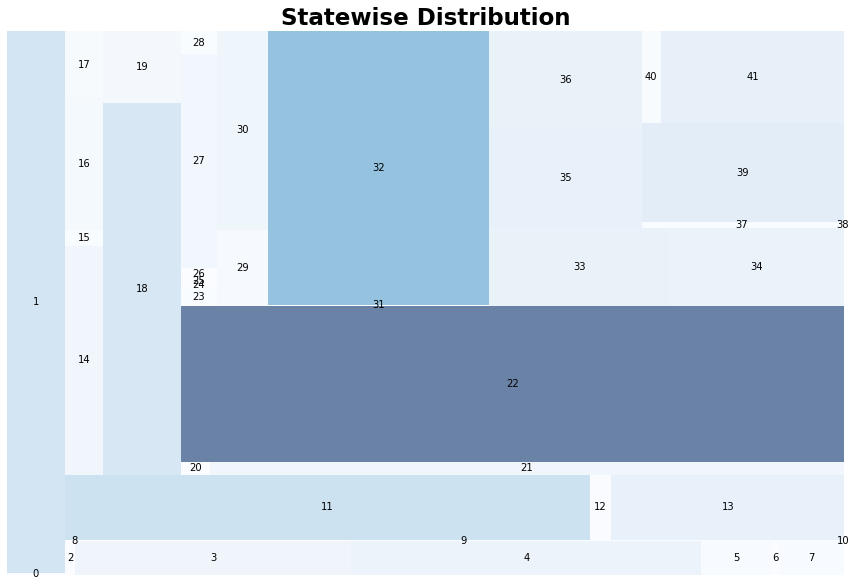

In [19]:
norm = matplotlib.colors.Normalize(vmin=min(state_cases.Confirmed), vmax=max(state_cases.Confirmed))
colors = [matplotlib.cm.Blues(norm(value)) for value in state_cases.Confirmed]

plt.figure(figsize= (15,10))
fig = plt.gcf()
ax = fig.add_subplot()

squarify.plot(label=list(state_cases.index),sizes=state_cases.Confirmed, color = colors, alpha=.6)

plt.title("Statewise Distribution",fontsize=23,fontweight="bold")
plt.axis('off')
plt.show()

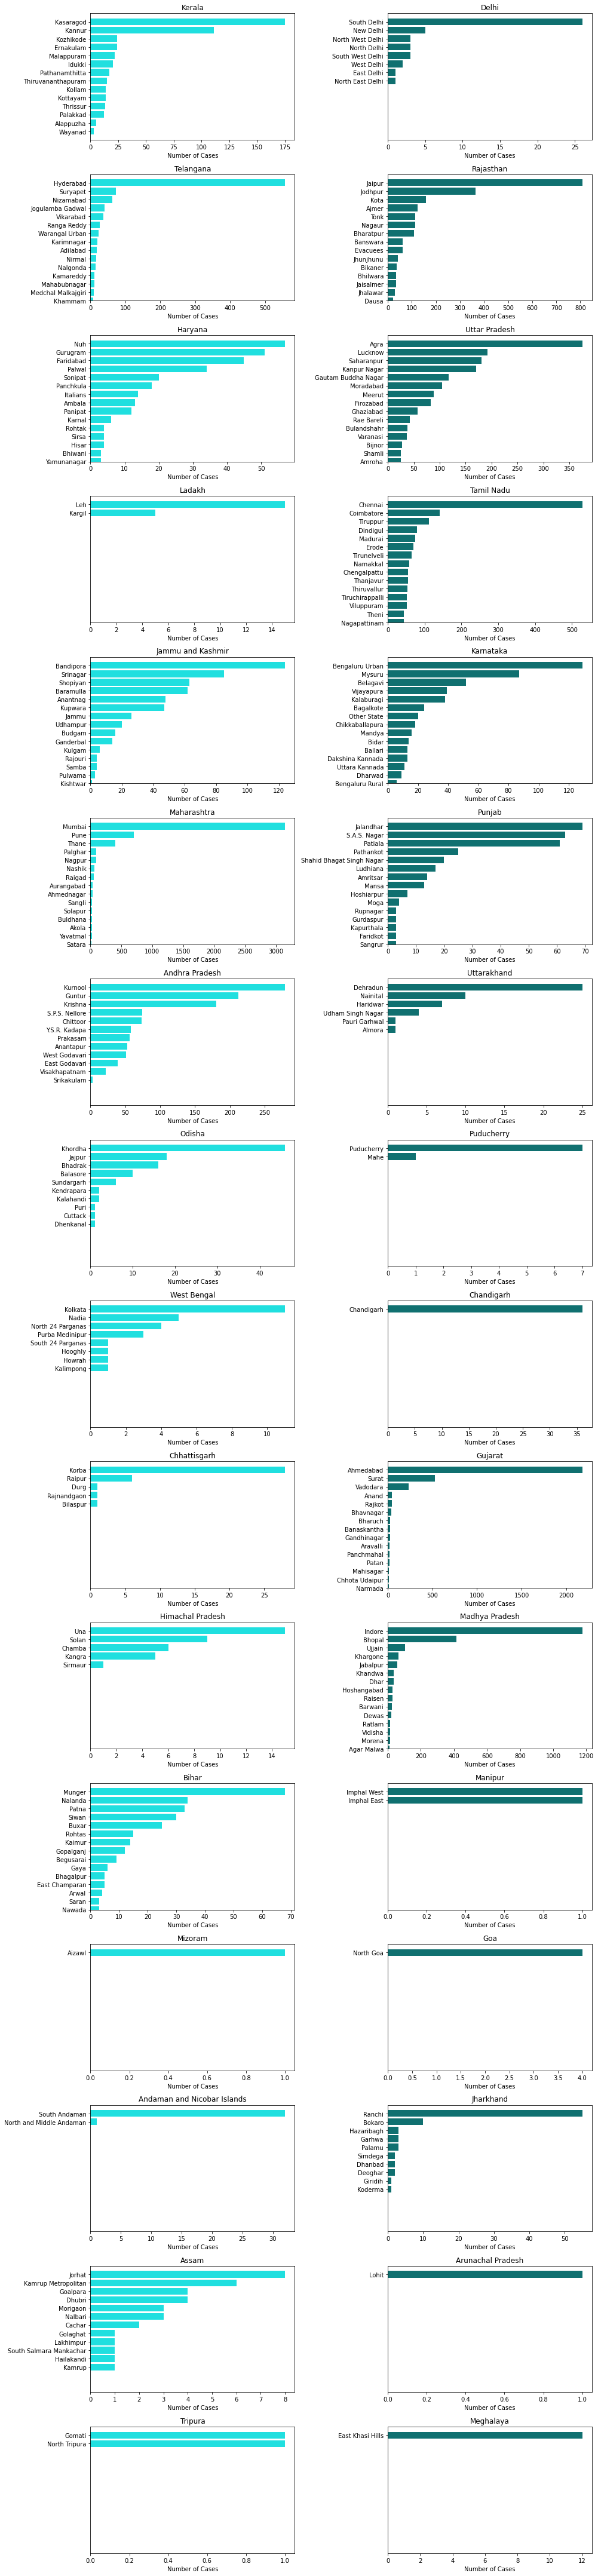

In [20]:
colors_list = ['cyan','teal']
states = individual_details['detected_state'].unique()
if len(states)%2==0:
    n_rows = int(len(states)/2)
else:
    n_rows = int((len(states)+1)/2)    
plt.figure(figsize=(14,60))

for idx,state in enumerate(states):    
    plt.subplot(n_rows,2,idx+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    try:
        g = sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',orient='v',color=colors_list[idx%2],order=y_order)
        plt.xlabel('Number of Cases')
        plt.ylabel('')
        plt.title(state)
        plt.ylim(14,-1)
    except:
        pass
plt.tight_layout()
plt.show()

Statewise Testing and Healthcare Insights 

In [21]:
hospital_beds =hospital_beds.drop([36])
cols_object = list(hospital_beds.columns[2:8])

for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors = 'ignore')

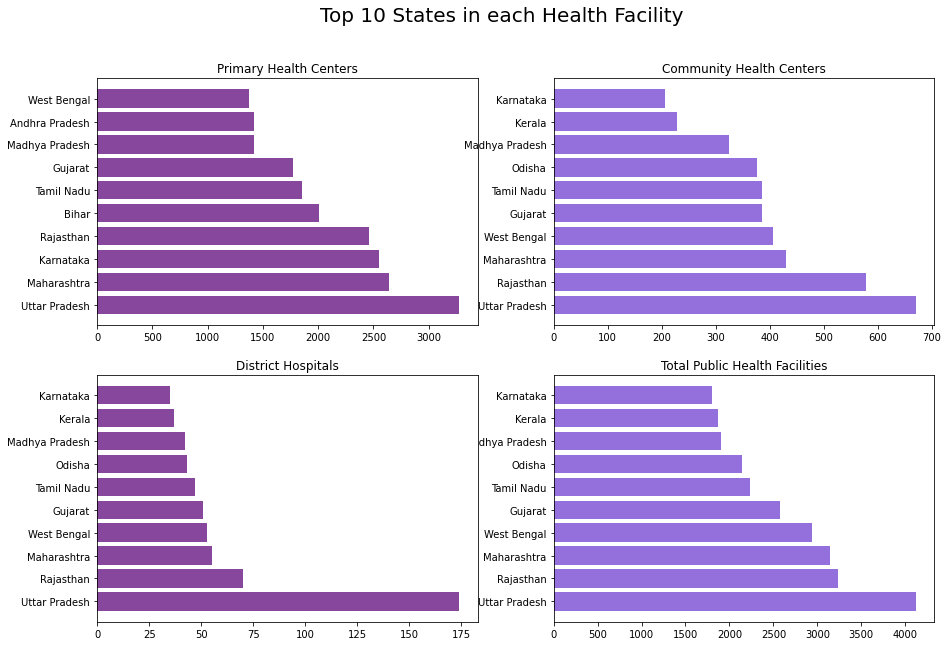

In [22]:
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

plt.figure(figsize=(15,10))
plt.suptitle('Top 10 States in each Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='#87479d');

plt.subplot(222)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db');

plt.subplot(224)
plt.title('Total Public Health Facilities')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db');

plt.subplot(223)
plt.title('District Hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = '#87479d');

In [23]:
state_testing

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0
5,2020-05-19,Andaman and Nicobar Islands,6965.0,NaN,33.0
6,2020-05-20,Andaman and Nicobar Islands,7082.0,NaN,33.0
7,2020-05-21,Andaman and Nicobar Islands,7167.0,NaN,33.0
8,2020-05-22,Andaman and Nicobar Islands,7263.0,NaN,33.0
9,2020-05-23,Andaman and Nicobar Islands,7327.0,NaN,33.0


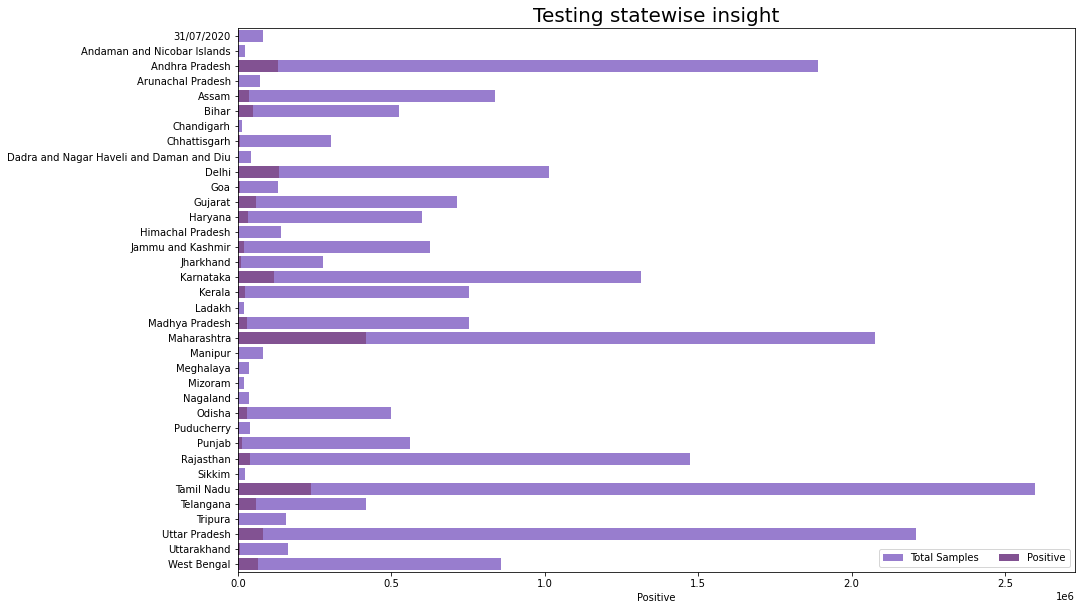

In [24]:
state_test = pd.pivot_table(state_testing, values=['TotalSamples','Negative','Positive'], index='State', aggfunc='max')
state_names = list(state_test.index)
state_test['State'] = state_names

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = '#9370db')
#sns.barplot(x='Negative', y=state_names, data=state_test,label='Negative', color= '#ff9999')
sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='#87479d')
plt.title('Testing statewise insight',fontsize = 20)
plt.legend(ncol=2, loc="lower right", frameon=True);

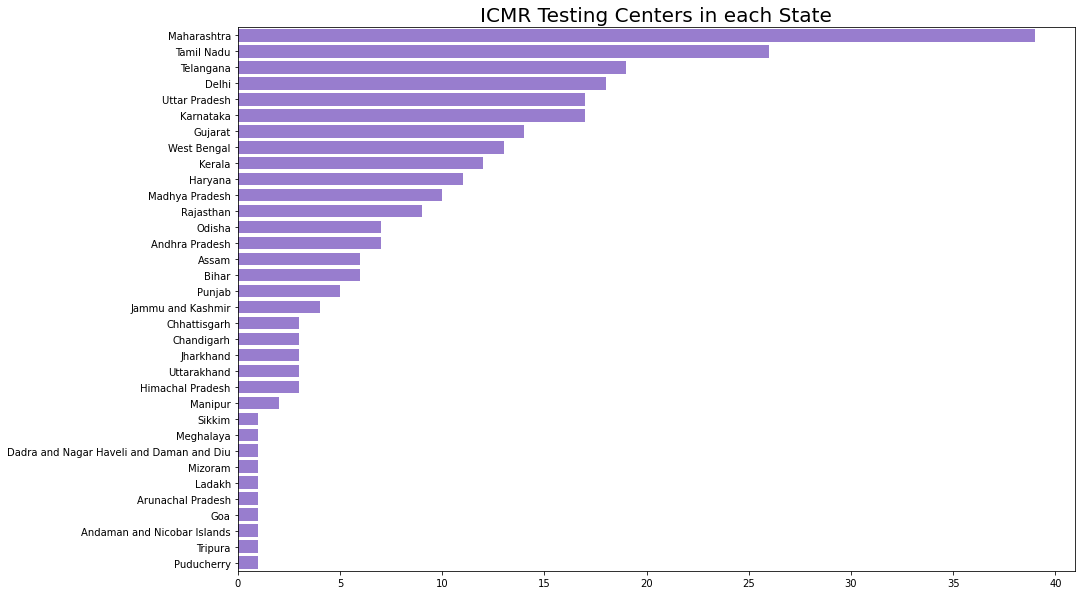

In [25]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#9370db');

# Prediction using GDP

Assuming the same GDP continues for the next 15 days

In [26]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.0537505642838092


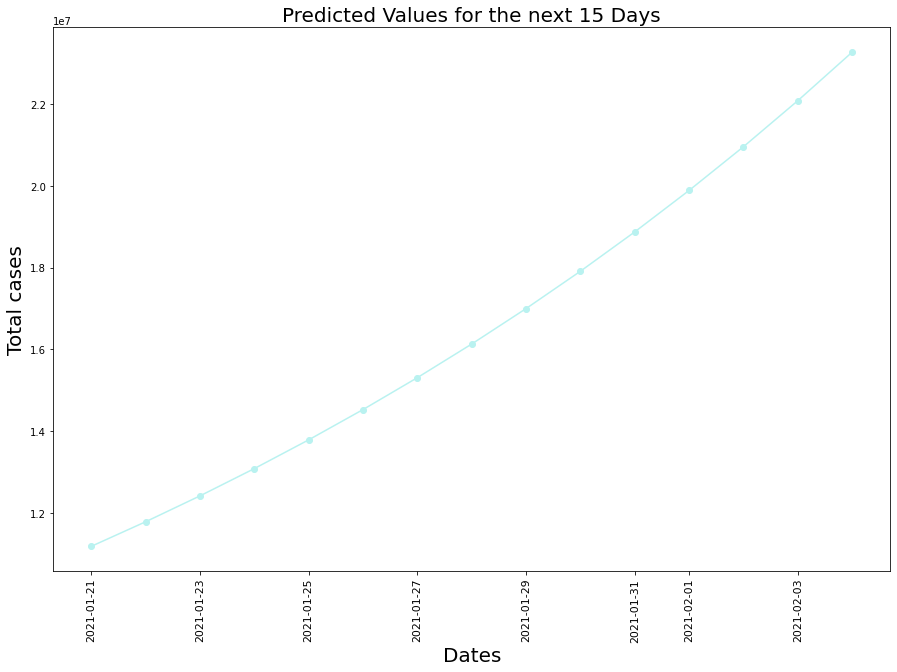

In [29]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')
plt.savefig('./static/images/predict.png')

In [30]:
train = pd.read_csv('data/covid19-global-forecasting-week-4/train.csv')
test = pd.read_csv('data/covid19-global-forecasting-week-4/test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


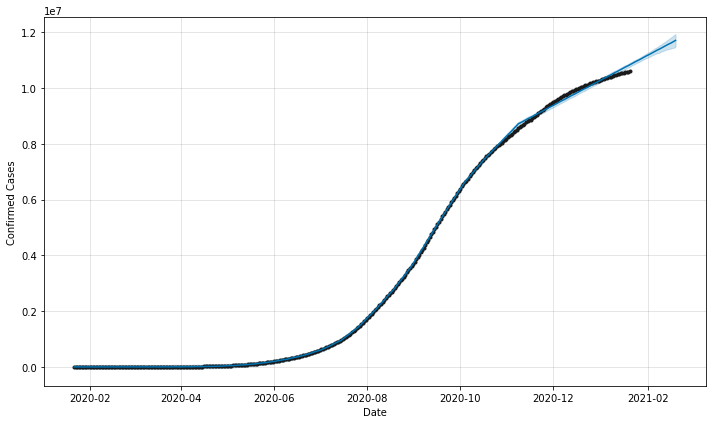

In [31]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

In [32]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['quarter'] = train['Date'].dt.quarter
train['weekofyear'] = train['Date'].dt.weekofyear
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['quarter'] = test['Date'].dt.quarter
test['weekofyear'] = test['Date'].dt.weekofyear
countries = list(train['Country_Region'].unique())
india_code = countries.index('India')
train = train.drop(['Date','Id'],1)
test =  test.drop(['Date'],1)

train.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
train[['Province_State','Country_Region']] = oe.fit_transform(train.loc[:,['Province_State','Country_Region']])

test.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
test[['Province_State','Country_Region']] = oe.fit_transform(test.loc[:,['Province_State','Country_Region']])

In [33]:
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State','Country_Region']
train = train[columns]
x = train.drop(['Fatalities','ConfirmedCases'], 1)
y = train['ConfirmedCases']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
test = test[test_columns]
test_india = test[test['Country_Region'] == india_code]

In [34]:
models = []
mse = []
mae = []
rmse = []

# LGBM Regression

In [35]:
lgbm = LGBMRegressor(n_estimators=1300)
lgbm.fit(x_train,y_train)
pred = lgbm.predict(x_test)
lgbm_forecast = lgbm.predict(test_india)
models.append('LGBM')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

[1777777.79]
[441.5]
[1333.33]


# Random Forest Regression

In [36]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
rfr_forecast = rf.predict(test_india)
models.append('Random Forest')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)


[1777777.79, 516810.32]
[441.5, 158.48]
[1333.33, 718.9]


# Lasso Regression

In [37]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
lasso_forecast = clf.predict(test_india)
models.append('Lasso')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

[1777777.79, 516810.32, 290738263.65]
[441.5, 158.48, 5835.93]
[1333.33, 718.9, 17051.05]


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
LR_forecast = clf.predict(test_india)
models.append('Logistic Regression')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

# XGBBOOSTER

In [30]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
xgb_forecast = xgb.predict(test_india)
models.append('XGBoost')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

[09:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[1777777.79, 528966.58, 157416419.57]
[441.5, 166.28, 4134.78]
[1333.33, 727.3, 12546.57]


# Tensorflow with Multiplex Layer

In [32]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(x_train,y_train, epochs=5, batch_size=10)


Epoch 1/5
2880/2880 [==============================] - 3s 875us/step - loss: -169679024.0000 - accuracy: 0.0419
Epoch 2/5
2880/2880 [==============================] - 2s 864us/step - loss: -2073377664.0000 - accuracy: 0.0309
Epoch 3/5
2880/2880 [==============================] - 3s 890us/step - loss: -7185804288.0000 - accuracy: 0.0309
Epoch 4/5
2880/2880 [==============================] - 3s 882us/step - loss: -16210886656.0000 - accuracy: 0.0309
Epoch 5/5
2880/2880 [==============================] - 3s 886us/step - loss: -30058543104.0000 - accuracy: 0.0309


In [40]:
# evaluate the keras model
_, accuracy = model.evaluate(x_train,y_train)
print('Accuracy: %.2f' % ((accuracy*30)*100))

900/900 [==============================] - 1s 747us/step - loss: -38975508480.0000 - accuracy: 0.0309
Accuracy: 92.72


In [43]:
pred = model.predict(x_test)

In [44]:
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

[1777777.79, 528966.58, 157416419.57, 542070.96, 516501.88, 317003361.1]
[441.5, 166.28, 4134.78, 162.28, 160.69, 3403.89]
[1333.33, 727.3, 12546.57, 736.25, 718.68, 17804.59]


# Arima Model

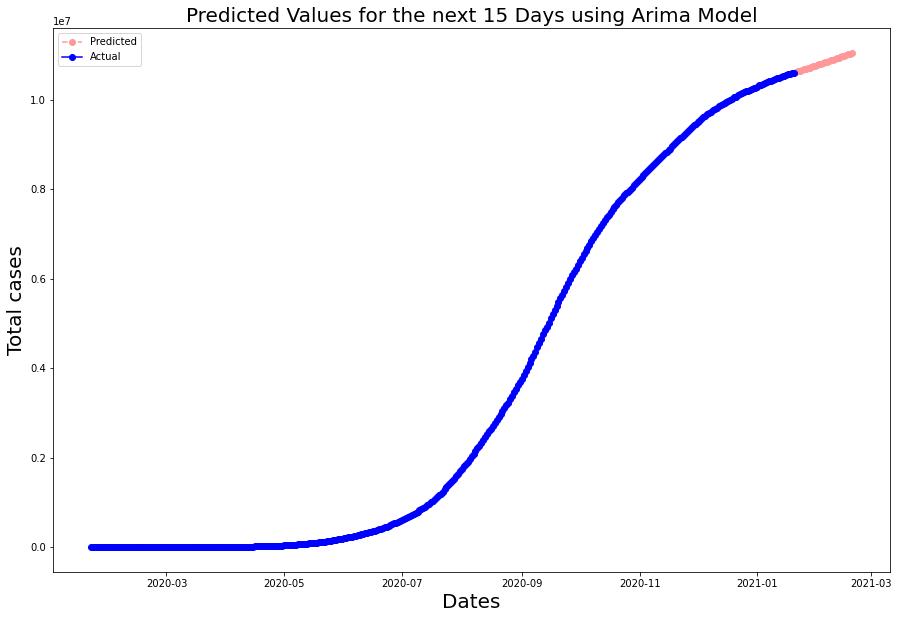

In [43]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days using Arima Model" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();
plt.savefig('./static/images/predict1.png')

# Flask Framework

In [40]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from werkzeug.wrappers import Request, Response

In [41]:
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('home.html')

@app.route('/home')
def home():
    return render_template('home.html')
@app.route('/about')
def about():
    return render_template('About.html')

@app.route('/dd')  
def dd():
    return render_template('Disease Description.html')

@app.route('/maps')
def maps():
    return render_template('Maps.html')

@app.route('/prediction')
def prediction():
    return render_template('index.html')

@app.route('/predict',methods=['POST'])
def predict():
    

    return render_template('index.html')

@app.route('/visual')
def visual():
    return render_template('visualize.html')

In [42]:
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

INFO:werkzeug: * Running on http://localhost:9000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET /static/css/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET /static/images/title.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET /static/images/7.jpeg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET /static/images/5.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET /static/images/download.jpeg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:49] "GET /static/images/6.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:53] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:20:57] "GET /dd HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 11:21:00] "GET /maps HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Feb/2021 1